In [1]:
import pcraster as pcr
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def getarg():
    """ Get program arguments.

    :return: args:  namespace of program arguments
    """
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-l', '--LDDDfile', type=str, required=True,
                        help='LISFLOOD LDDD file (ldd.nc)')
    parser.add_argument('-i', '--Inputfile', type=str, required=True,
                        help='Input nc file from where the values of the downstream areas will be extracted')
    parser.add_argument('-X', '--Location_x', type=str, required=True,
                        help='Longitude of the initial point [use the same projection system as the input nc files!]')
    parser.add_argument('-Y', '--Location_y', type=str, required=True,
                        help='Latitude of the initial point [use the same projection system as the input nc files!]')
    parser.add_argument('-E', '--coordsnames', type=str, nargs='+', required=False, default="None",
                        help='Coords names for lat, lon (in this order with space!) from the netcdf files used')
    parser.add_argument('-O', '--outputfilename', type=str, required=False, default="profiler.csv",
                        help='Output file (profiler.csv)')
    args = parser.parse_args()  # assign namespace to args
    return args

In [3]:
final_data = xr.open_dataset('/home/ecm8227//Repositories/lisflood-utilities/src/lisfloodutilities/chanbw.nc')
final_data = xr.open_dataset('/ec/vol/efas/static_data/5.0/parameters/PowerPrefFlow.nc')
LDD = xr.open_dataset('/home/ecm8227//Repositories/lisflood-utilities/src/lisfloodutilities/ldd.nc')

/usr/local/apps/python3/3.11.8-01/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
coords_names = "None"
x_checks = ['lon', 'x', 'rlon']
y_checks = ['lat', 'y', 'rlat']
if coords_names == "None":
    x_proj = set(list(LDD.coords)) & set(x_checks)
    y_proj = set(list(LDD.coords)) & set(y_checks)

    if len(x_proj)!=1 or len(y_proj)!=1:
        print('Input dataset coords names for lat/lon are not as expected.')
        print(f'The available coords are: {list(LDD.coords)}')
        print(f'The checked names are {y_checks} and {x_checks} for lat and lon respectively.')
        print('Please use -E argument and give the coords names !with space in between! in order: lan lon')
        exit(1)
    
    x_proj = list(x_proj)[0]
    y_proj = list(y_proj)[0]
else:
    y_proj, x_proj = coords_names

In [5]:
old_name = [i for i in list(LDD.data_vars) if sorted(LDD[i].dims)==sorted([x_proj, y_proj])]
LDD = LDD.rename({old_name[0]: "ldd"})['ldd']  # only 1 variable complies with above if

# sometimes the masked value is flagged not with NaN (e.g., with cutmaps it was flagged with 0)
# pcr.Ldd takes only integer values 1-9, so any other value needs to be masked
LDD = LDD.fillna(-1)  # fill NaN so it can be converted to integer with no issues
LDD = LDD.astype('int')
LDD = LDD.where((LDD>0) & (LDD<10)).fillna(-1)

# convert the xarray to pcraster
LDD = LDD.transpose(y_proj, x_proj)  # make sure dims order is as pcraster needs

rows, cols = len(LDD[y_proj]), len(LDD[x_proj])
pcr.setclone(rows, cols, 1, 0, 0)

In [6]:
ldd_pcr = pcr.numpy2pcr(pcr.Ldd, LDD.values, -1)  # missing values in the np are flagged as -1

# repair the ldd; needed in case ldd is created from cutmaps, so outlet is not flagged with 5 (pit) 
ldd_pcr = pcr.lddrepair(ldd_pcr)

In [7]:
# Y = LDD.lat[1510].values
# X = LDD.lon[1400].values

In [8]:
X = 12.141 
Y = 49.025

In [9]:
try:
    final_point = LDD.sel({y_proj:Y, x_proj: X} , method='nearest', tolerance=0.01)
except:
    print('Provided coordinates are not valid, please check again!')
    exit()
    
Y_index = np.argmax(LDD[y_proj].values==final_point[y_proj].values)
X_index = np.argmax(LDD[x_proj].values==final_point[x_proj].values)

profile_mask_pcr = LDD.fillna(0)*0

profile_mask_pcr[Y_index, X_index] = 1
profile_mask_pcr = profile_mask_pcr.astype('int')

In [10]:
profile_mask_pcr = pcr.numpy2pcr(pcr.Boolean, profile_mask_pcr.values, -1)  # convert to Boolean with no NaN (-1 is not possible)
profile_mask_pcr = pcr.path(ldd_pcr, profile_mask_pcr)  # get the actual paths

In [11]:
profile_mask_np = pcr.pcr2numpy(profile_mask_pcr, 0)
ProfPath = LDD.fillna(0)*0+profile_mask_np
ProfPath = ProfPath.where(ProfPath==1)
ProfPath.name = 'Profile'
total_points = int(ProfPath.sum().values)
total_points

1599

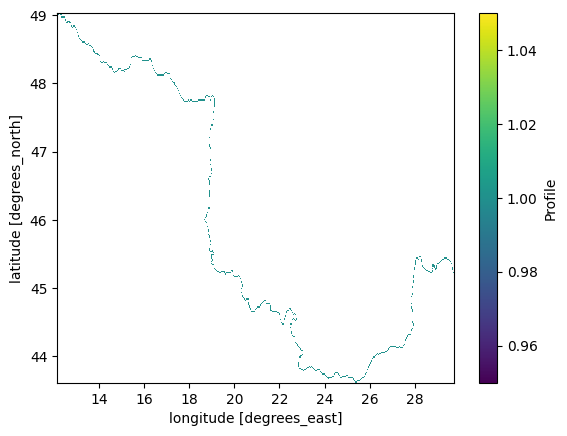

In [12]:
lats_used = ProfPath.sum(x_proj).where(ProfPath.sum(x_proj)!=0).dropna(y_proj)
lons_used = ProfPath.sum(y_proj).where(ProfPath.sum(y_proj)!=0).dropna(x_proj)

ProfPath = ProfPath.sel({y_proj:lats_used[y_proj].values, x_proj:lons_used[x_proj].values})
ProfPath.plot()

In [13]:
# define clone for pcraster, otherwise it gets any clone available which can be wrong
rows, cols = len(ProfPath[y_proj]), len(ProfPath[x_proj])
pcr.setclone(rows, cols, 1, 0, 0)

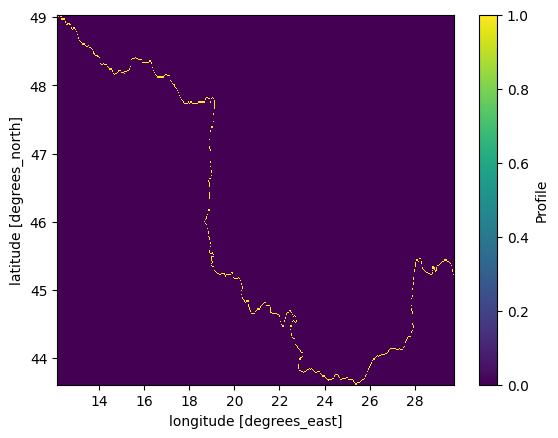

In [14]:
rivers_mask_pcr = pcr.numpy2pcr(pcr.Scalar, ProfPath.values, 0)
(ProfPath.fillna(0)*0+pcr.pcr2numpy(rivers_mask_pcr, 0)).plot()

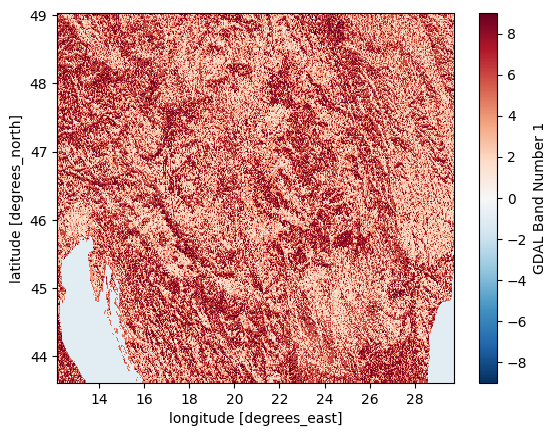

In [15]:
ldd_pcr = LDD.sel({y_proj: ProfPath[y_proj].values, x_proj: ProfPath[x_proj].values})
ldd_pcr.plot()
ldd_pcr = pcr.numpy2pcr(pcr.Ldd, ldd_pcr.values, -1)

In [16]:
downstream_cells_pcr = rivers_mask_pcr
sum_rivers_pcr = rivers_mask_pcr

downstream_actual_mask_pcr = pcr.downstreamdist(ldd_pcr)
downstream_actual_mask_pcr = pcr.ifthenelse(downstream_actual_mask_pcr == 0, pcr.boolean(0), pcr.boolean(1))
downstream_actual_mask_pcr = pcr.scalar(downstream_actual_mask_pcr)

# Loop number of cells -1 times and use downstream function to find out the order of the cells on the river flow
for loops in tqdm(range(total_points-1)):
    downstream_cells_pcr = pcr.downstream(ldd_pcr, downstream_cells_pcr)
    downstream_cells_pcr = downstream_cells_pcr*downstream_actual_mask_pcr
    sum_rivers_pcr = sum_rivers_pcr + downstream_cells_pcr

100%|██████████| 1598/1598 [00:07<00:00, 209.69it/s]


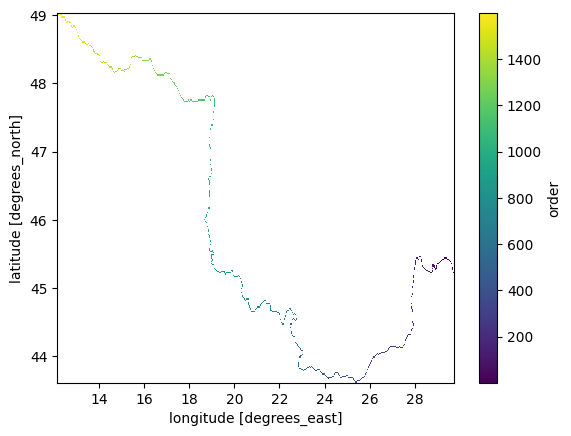

In [17]:
sum_rivers = (ProfPath.fillna(0)*0+pcr.pcr2numpy(sum_rivers_pcr, 0))
sum_rivers.name = 'order'
sum_rivers.where(sum_rivers!=0).plot()

In [18]:
final_data = final_data.sel({y_proj: ProfPath[y_proj].values, x_proj: ProfPath[x_proj].values})
LDD = LDD.sel({y_proj: ProfPath[y_proj].values, x_proj: ProfPath[x_proj].values})
all_data = xr.merge([final_data, LDD, ProfPath, sum_rivers])

In [34]:
all_data_df = all_data.to_dataframe().reset_index()
all_data_df = all_data_df[~all_data_df.Profile.isna()]
all_data_df = all_data_df.sort_values('order')
all_data_df.index = range(len(all_data_df))
all_data_df

,lon,lat,PowerPrefFlow,ldd,Profile,order
0,29.725000,45.225000,1.81158,5.0,1.0,1.0
1,29.708333,45.241667,1.81158,3.0,1.0,2.0
2,29.691667,45.258333,1.81158,3.0,1.0,3.0
3,29.675000,45.275000,1.81158,3.0,1.0,4.0
4,29.675000,45.291667,1.81158,2.0,1.0,5.0
...,...,...,...,...,...,...
1594,12.208333,49.025000,3.63735,6.0,1.0,1595.0
1595,12.191667,49.008333,3.63735,9.0,1.0,1596.0
1596,12.175000,49.008333,3.63735,6.0,1.0,1597.0
1597,12.158333,49.025000,3.63735,3.0,1.0,1598.0


In [20]:
import seaborn as sns

In [47]:
all_data_df2 = pd.read_csv('profiler/test.csv', index_col=0)
all_data_df2.index = range(len(all_data_df2))
all_data_df2

,lat,lon,PowerPrefFlow,wgs_1984,ldd,Profile,order
0,45.225,29.725,4.00000,-2147483647,5.0,1.0,1.0
1,45.275,29.675,1.57526,-2147483647,3.0,1.0,2.0
2,45.325,29.675,1.57526,-2147483647,2.0,1.0,3.0
3,45.375,29.625,1.57526,-2147483647,3.0,1.0,4.0
4,45.375,29.575,1.57526,-2147483647,6.0,1.0,5.0
...,...,...,...,...,...,...,...
515,49.025,12.325,6.94425,-2147483647,2.0,1.0,516.0
516,49.025,12.275,6.94425,-2147483647,6.0,1.0,517.0
517,49.025,12.225,6.94425,-2147483647,6.0,1.0,518.0
518,49.025,12.175,6.94425,-2147483647,6.0,1.0,519.0


In [46]:
np.round(np.abs(all_data_df2-all_data_df).max(), 6)

PowerPrefFlow    0.0
Profile          0.0
lat              0.0
ldd              0.0
lon              0.0
order            0.0
dtype: float64

<Axes: xlabel='order', ylabel='PowerPrefFlow'>

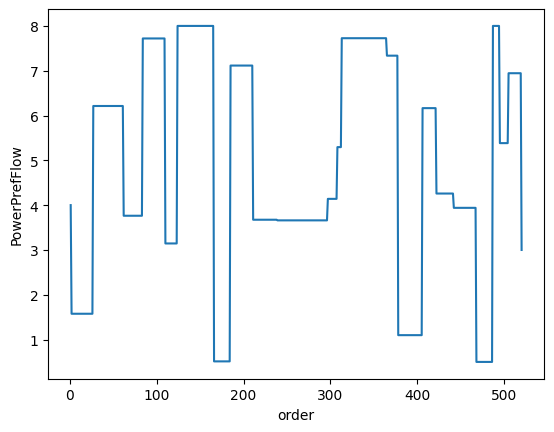

In [49]:
sns.lineplot(data=all_data_df2, x='order', y='PowerPrefFlow')

<Axes: xlabel='order', ylabel='PowerPrefFlow'>

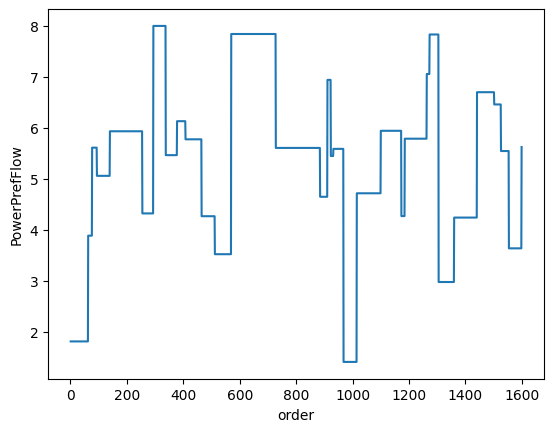

In [23]:
sns.lineplot(data=all_data_df, x='order', y='PowerPrefFlow')

<Axes: xlabel='lon', ylabel='lat'>

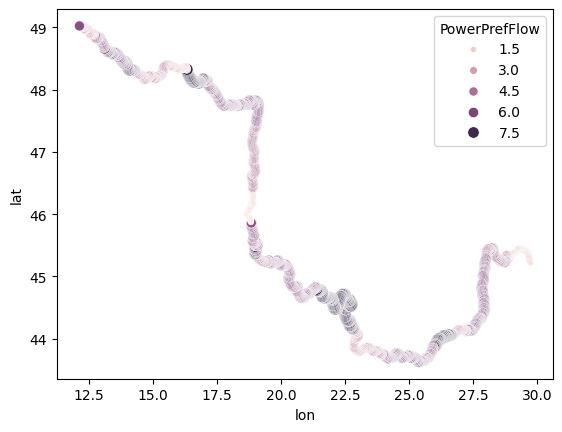

In [25]:
sns.scatterplot(data=all_data_df, x=x_proj, y=y_proj, hue='PowerPrefFlow', size='PowerPrefFlow')

<Axes: xlabel='lon', ylabel='lat'>

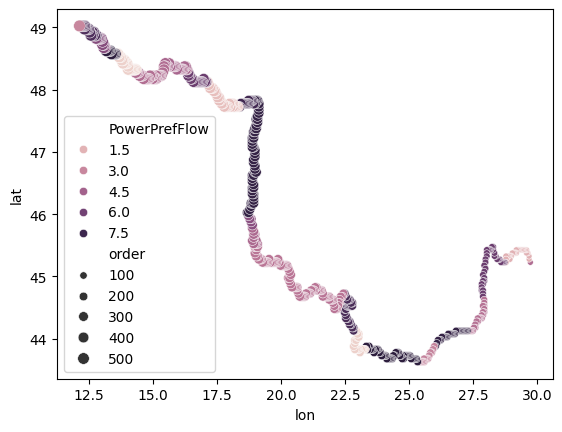

In [50]:
sns.scatterplot(data=all_data_df2, x=x_proj, y=y_proj, hue='PowerPrefFlow', size='PowerPrefFlow')